In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib, wandb
import matplotlib as mpl
import numpy as np

In [3]:
api = wandb.Api(timeout=300)

# Project is specified by <entity/project-name>
runs = api.runs("lee-lab-uw-madison/lora-expressive-power")

In [4]:
df = pd.read_pickle('../results/results.pkl')

In [5]:
def get_rows(
    args_dict,
):
    idx = {}
    for key, value in args_dict.items():
        if value is None:
            idx[key] = np.ones_like(df[key], dtype=bool)
        else:
            idx[key] = df[key] == value
        
    run_idx = np.ones_like(df['test_loss'], dtype=bool)
    for key, value in idx.items():
        run_idx = run_idx & value
    
    # print(f"Selected {run_idx.sum()} runs!")
    
    run_df = df[run_idx].reset_index(drop=True)   
    return run_df

In [6]:

activation = 'relu'
use_bias = 1
width = 16
exp = 'fnn'
init_mode = 'default'
pretrained = 0

fnn_results = {}
for target_depth in [1,2]:
    frozen_depth = 2 * target_depth
    fnn_results[target_depth] = {}
    for rank in range(1, width+1):
        results = get_rows({
            'activation': activation,
            'use_bias': use_bias,
            'target_depth': target_depth,
            'frozen_depth': frozen_depth,
            'init_mode': init_mode,
            'width': width,
            'exp': exp,
            'pretrained': pretrained,
            'rank_step': 0,
            'task': 'regression',
            'rank': rank,
            'n_epochs': 5000,
        })
        best_idx = results['val_loss'].idxmin()
        best_run_id = results['run_id'].loc[best_idx]
    
        best_run = api.run(f'lee-lab-uw-madison/lora-expressive-power/{best_run_id}')
        
        fnn_results[target_depth][rank] = best_run.history(keys = ['train_loss'], samples = 5000)

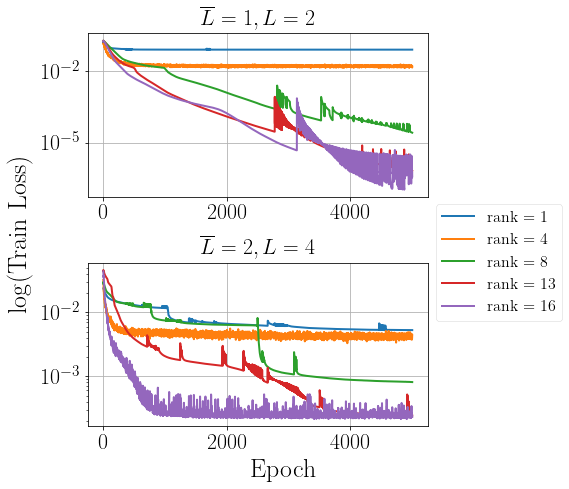

In [9]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

rank_set = [1,4,8,13,16]

fig, ax = plt.subplots(nrows=2, ncols=1, sharey = False)
fig.subplots_adjust(left=0.16, bottom=.12, right=0.75, top=0.9, wspace=0.25, hspace = 0.4) #margin of the figure
fig.set_size_inches(8, 7) #exact size of the figure

for j, rank in enumerate(rank_set):
    for i, target_depth in enumerate([1,2]):
    
        fnn_results[target_depth][rank].plot(y='train_loss', ax = ax[i], label = f'rank = {rank}', linewidth = 2, logy = True)
        # remove the legend of the first subplot
        ax[i].legend().set_visible(False)
        ax[i].grid(True)
        
ax[0].set_title(r'$\overline{L}=1, L=2$', size = 22, y = 1.01)
ax[1].set_title(r'$\overline{L}=2, L=4$', size = 22, y = 1.01)

fig.supxlabel('Epoch', fontsize = 26)
fig.supylabel(r'$\log$(Train Loss)', fontsize = 26)

# set the legend beside the plot 
ax[1].legend(loc='center left', bbox_to_anchor=(1, 1), fontsize = 16)
# ax[0].legend(fontsize=15, bbox_to_anchor=(0.37,0.51), ncols = 2)

plt.savefig('../figures/convergence.pdf')
# Show the plot
plt.show()

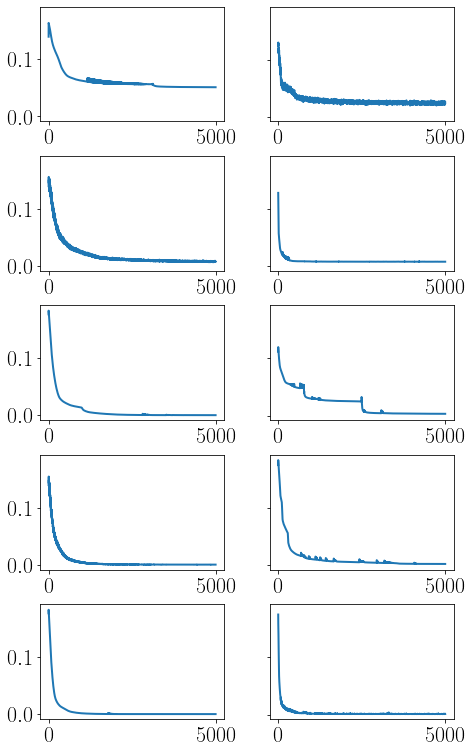

In [8]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

rank_set = [2,5,8,11,14]

fig, ax = plt.subplots(nrows=len(rank_set), ncols=2, sharey = 'col')
fig.subplots_adjust(left=0.16, bottom=.24, right=0.98, top=0.9, wspace=0.25, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 15) #exact size of the figure

for i, rank in enumerate(rank_set):
    for j, target_depth in enumerate([1,2]):
    
        fnn_results[target_depth][rank].plot(y='train_loss', ax = ax[i][j], label = f'rank = {rank}', linewidth = 2)
        # remove the legend of the first subplot
        ax[i][j].legend().set_visible(False)
        
        